In [107]:
import pandas as pd
import numpy as np
import preprocess

In [108]:
df_joao_annotated = pd.read_json('phillipe_annotion.json', lines=True)

In [3]:
df2 = df_joao_annotated.drop_duplicates(subset=['tweet_id'], keep='first')

In [4]:
df2

,tweet_id,img_label,txt_label,work_time,orig_path,text,img
0,1437188092683751424,Irrelevant,Irrelevant,23.626190,social-data/media_12/pt/1437188092683751429/im...,Simone ja esta gravando um novo clipe para “En...,annotated-data/1437188092683751429.jpg
1,1435028621362614272,Irrelevant,Irrelevant,23.626190,social-data/media_07/pt/1435028621362614277/im...,"✅ Dominado Vila Real, Vila Pouca De Aguiar, Pe...",annotated-data/1435028621362614277.jpg
2,1435346675674013696,Irrelevant,Irrelevant,23.626190,social-data/media_07/pt/1435346675674013701/im...,EVANGELINE LILLY EU TE AMO EU TE AMOOOO https...,annotated-data/1435346675674013701.jpg
3,1437130100718383104,Irrelevant,Relevant (Related),23.626190,social-data/media_12/pt/1437130100718383105/im...,"Aqui de boa na rede, enquanto o MBL passa verg...",annotated-data/1437130100718383105.jpg
4,1435211167924957184,Irrelevant,Irrelevant,21.878664,social-data/media_07/en/1435211167924957190/im...,"@Khayizasoze I was sent this picture,sengiyasa...",annotated-data/1435211167924957190.jpg
...,...,...,...,...,...,...,...
4995,1436688481242255360,Irrelevant,Irrelevant,15.889647,social-data/media_8_11/pt/1436688481242255361/...,@Mano_Cebola1 ELE D NOVO SIIIIIM! E AINDA TEM ...,annotated-data/1436688481242255361.jpg
4996,1436071900803915776,Irrelevant,Relevant (Related),20.498567,social-data/media_8_11/pt/1436071900803915776/...,"Pois, é! Máscaras caindo… #BolsonaroArregou e ...",annotated-data/1436071900803915776.jpg
4997,1436067261094236160,Irrelevant,Irrelevant,20.498567,social-data/media_8_11/pt/1436067261094236169/...,Um móvel novo é sempre bem vindo para renovar ...,annotated-data/1436067261094236169.jpg
4998,1435440766868987904,Irrelevant,Relevant (Related),20.498567,social-data/media_8_11/pt/1435440766868987907/...,Descobri que zoar Bolsominions é bom pro engaj...,annotated-data/1435440766868987907.jpg


In [54]:
clean_text = [] 

for index, row in df2.iterrows():
    clean_text.append(preprocess.pre_process(row['text'], keep_hashtag = True, keep_special_symbols = True))

df2['processed_tweet'] = clean_text

## Data Shuffle and Separation

In [58]:
df_shuf = df2.sample(frac=1, random_state=0).reset_index(drop=True)

In [59]:
df_train = df_shuf.iloc[:4000]
df_test  = df_shuf.iloc[4000:]

## First Iteration

In [61]:
df1 = df_train#.iloc[:1000]

In [49]:
from sentence_transformers import SentenceTransformer, util
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [50]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Text Embeddings

In [51]:
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

In [62]:
tweets_emds = model.encode(df1['processed_tweet'].tolist())
df1['tweet_embeddings'] = tweets_emds.tolist()

<ipython-input-62-79488a430664>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tweet_embeddings'] = tweets_emds.tolist()


## Image Embeddings

In [7]:
from forensic_lib.forensicsEvidences.imgEv.CNN import  load_default_image_model_or_preprocess, get_image_embedding
from forensic_lib.utils.img_utils import load_image
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

/root/miniconda3/envs/russiawar/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
image_paths = [m for m in df1['img'].values]
image_ids = [ i  for i in df1.index]
model, m_transform = load_default_image_model_or_preprocess()
embeddings, embeddings_ids  = get_image_embedding(image_paths, image_ids, model, m_transform, gpu_id=1, use_gpu=True)

Model on GPU              


100%|██████████| 63/63 [00:30<00:00,  2.08it/s]

Model on CPU             


In [65]:
df1['img_embeddings'] = embeddings.tolist()

<ipython-input-65-b50ee4edaacd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['img_embeddings'] = embeddings.tolist()


### Leiden Clustering

In [92]:
cos_mat_img = util.cos_sim(df1['img_embeddings'].tolist(),df1['img_embeddings'].tolist())
cos_mat_txt = util.cos_sim(df1['tweet_embeddings'].tolist(),df1['tweet_embeddings'].tolist())

In [93]:
cos_copy = np.maximum(cos_mat_img.detach().cpu().numpy(), cos_mat_txt.detach().cpu().numpy())

In [94]:
cos_copy = cos_mat.detach().cpu().numpy()

In [95]:
import networkx as nx
import leidenalg as la
import igraph as ig

In [96]:
cos_copy[cos_copy < 0.85] = 0

In [97]:
G = nx.from_numpy_array(cos_copy)
g = ig.Graph.from_networkx(G)
communities = la.find_partition(g, la.ModularityVertexPartition, n_iterations=-1)
optimizer = la.Optimiser()        
diff = 1
while diff > 0:
    diff = optimizer.optimise_partition(communities,n_iterations=-1)

In [46]:
G = nx.from_numpy_array(cos_copy)
componnets = nx.connected_components(G)


communities = []
for cc in componnets:
    a = G.subgraph(cc)
    if a.number_of_nodes() >= 10:
        communities.append(a.copy()) 


In [48]:
for i in communities:
    print(len(i))

94
275
23


In [106]:
# communities[0]

In [35]:
df1.iloc[355]

tweet_id                                        1435421091443449856
img_label                                    Relevant (Informative)
txt_label                                    Relevant (Informative)
work_time                                                 14.794955
orig_path         social-data/media_8_11/pt/1435421091443449858/...
text              Fortelza na RUA e na luta pelo Fora Bolsonaro!...
img                          annotated-data/1435421091443449858.jpg
img_embeddings    [0.11678485572338104, 0.3392501175403595, -0.1...
Name: 355, dtype: object

In [75]:
# find the degree within a community
list(set(communities[0]).intersection(communities.graph.neighborhood(communities[0][1])))

[482, 15, 2289, 2803, 412]

In [109]:
print(communities.graph.neighborhood(communities[0][1]))
len(communities.graph.neighborhood(communities[0][1]))

[24, 1209, 1734]


3

In [110]:
print((communities.graph.degree()[355]))

47


In [111]:
# Todo: 
# - sort by the degree inside the community

In [26]:
df1.iloc[communities.graph.neighborhood(3846)]

,tweet_id,img_label,txt_label,work_time,orig_path,text,img,img_embeddings
3846,1437107272476499968,Irrelevant,Irrelevant,26.927878,social-data/media_12/pt/1437107272476499970/im...,viva o sus e pau no cu do Bolsonaro 🥰 https:/...,annotated-data/1437107272476499970.jpg,"[0.025595773011446, 0.3506164848804474, -0.201..."


In [98]:
for i in sorted(range(len(communities[1])), key=lambda x: len(set(communities[1]).intersection(communities.graph.neighborhood(communities[1][x]))), reverse=True):
    degree = len(set(communities[1]).intersection(communities.graph.neighborhood(communities[1][i])))
    print(communities[1][i], degree, df1.iloc[communities[1][i]]['text'], df1.iloc[communities[1][i]]['img_label'],  sep='|  ')
    print()

211|  7|  José Sarney foi filiado durante 20 anos ao ARENA, O PARTIDO DA DITADURA MILITAR (chegando até a presidir a legenda) regime esse que LITERALMENTE perseguiu e matou militantes de esquerda, "companheiros" do Lula.  https://t.co/hLq8g41bON|  Irrelevant

856|  5|  Meses atrás quando tive essa conversa sobre a porra de um meme, lá trás quando eu ainda tinha vontade de ajudar a criar uma comunidade num discord de Arknights  Vendo essa conversa de novo... me fez lembrar um dos motivos por que sai.  https://t.co/eQ7IjiiABT|  Irrelevant

1639|  5|  Só um lembrete para nós, o povo:  Por 18 dias o povo do Egito tomou as ruas, em protesto contra o presidente Hosni Mubarak, que governou o país por 30 anos. Mesmo sob ameaças de confrontos violentos, a população resistiu. A Praça Tahrir, no Cairo, capital do país, virou um enorme  https://t.co/6jDNE0pPcJ|  Irrelevant

2264|  5|  Amei. O foco é tirar o Bozo. A.  https://t.co/AXpiDGMS6H|  Irrelevant

990|  4|  ⚠️ Alerta WPP bolsonarista ⚠️  De

In [109]:
dict_stats = {}
k = 0
for i in range(len(communities)):
    if not dict_stats.get(len(communities[i])):
        dict_stats[len(communities[i])] =0
    dict_stats[len(communities[i])] +=1

In [110]:
dict_stats

{121: 1, 13: 1, 12: 1, 10: 1, 9: 1, 8: 1, 6: 1, 4: 1, 3: 7, 2: 28, 1: 3740}

In [178]:
dict_stats = pd.DataFrame()
k = 0
for i in range(len(communities)):
    if len(communities[i]) == 121 :
        for j in range(121):
            dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])

<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method i

<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method i

<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_stats=  dict_stats.append(df1.iloc[communities[i][j]])
<ipython-input-178-b55b1e8672a7>:6: FutureWarning: The frame.append method i

In [150]:
dict_stats[['img_label','txt_label']].describe()

,img_label,txt_label
count,3740,3740
unique,4,4
top,Irrelevant,Irrelevant
freq,2770,2267


In [165]:
df1[['img_label','txt_label']].countt_values

AttributeError: 'DataFrame' object has no attribute 'countt_values'

<AxesSubplot:xlabel='img_label,txt_label'>

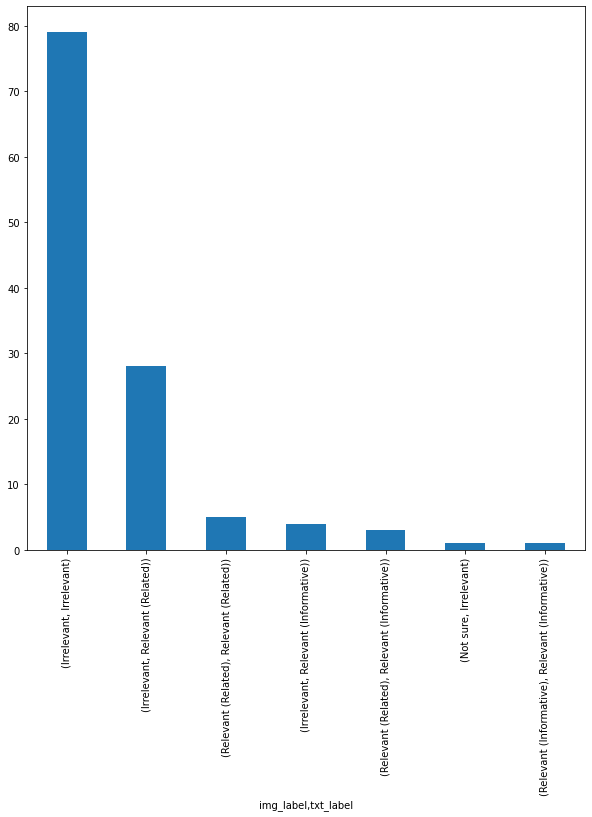

In [179]:
plt.figure(figsize=(10,10))
dict_stats[['img_label','txt_label']].value_counts().plot(kind='bar')

In [182]:
for _, row in dict_stats[['text','txt_label']].iterrows():
    print(row['text'], row['txt_label'])
    print()

@anonymousBROF best manda isso pro bolsonaro  https://t.co/A3hanyRV3q Relevant (Related)

CYSS invites you to join  Online classes for MA, MPHIL, PHD for DU and JNU entrance exam 2021-2022 Topic -  Revision Classes for Political Science Part I - Political Theory Date -  7/09/2021 Time - 4:00-6:00 pm Google meet link  https://t.co/lPXxhicquA  https://t.co/U9NEtM6HRm Irrelevant

i don’t normally do this but i really need y’all to go block and report, don’t even engage with them  https://t.co/zb9HeIUOX2 Irrelevant

@EmliaTeixeira13 @guimaraes13PT Lista da rachadinha do Queiroz o lider ptista o lula emcionou bem seus discípulos!  https://t.co/Y9uMWk41E2 Irrelevant

@_danielaabade As manifestações e o golpe esvaíram-se num pum amarelo do palhaço Bolsonaro. A única invasão foi da Esplanada. Não resistiram à grama.  https://t.co/NnPvBmU8OH Relevant (Informative)

Esquerda contra a liberdade de expressão ➡️➡️➡️➡️➡️➡️⬇️  https://t.co/aUWe7dtRi3 Irrelevant

7. chills pt. 2  https://t.co/nPxB4KL3

In [113]:
dict_com = {}
k = 0
for i in range(len(communities)):
    if (len(communities[i])>0):
        dict_com[k] = df1.loc[df1.index[communities[i]]]
        k += 1

In [114]:
# dict_com[0]
len(dict_com)

3783

In [144]:
i = 1055
print(len(dict_com[i]))
for index, row in dict_com[i].iterrows():
        print(row['processed_tweet'])
#         print(row['tweet_id'])
        print(row['txt_label'])
        print("=============")

1
E JA SEGUIMOS PRA 2 SESSÃO DE TESTES!! SERA QUE E DOMINAN DE NOVO??
Irrelevant


### Select samples from the cluster

In [75]:
# from random import sample
# dict_com[0].sample(n=10, random_state=2)[['text','txt_label', 'img_label']]

In [101]:
sorted_id = [communities[0][i]  for i in sorted(range(len(communities[0])), key=lambda x: len(set(communities[0]).intersection(communities.graph.neighborhood(communities[0][x]))), reverse=True)]

In [87]:
k=1
sorted_id = [communities[k][i]  for i in sorted(range(len(communities[k])), key=lambda x: len(set(communities[k]).intersection(communities.graph.neighborhood(communities[k][x]))), reverse=True)]

In [102]:
df_sample = df1.iloc[sorted_id[:10]]
#print(df_sample.txt_label.value_counts()['Relevant (Informative)'])

In [103]:
def tweet_label(tweet):
    """
    Get a label for the entire tweet based on the label
    of each modality
    
    Return:
        True -- tweet is relevant
        False -- tweet is irrelvant
    """
    img_label = tweet['img_label']
    txt_label = tweet['txt_label']
    
    # case (Informative, Informative)
    #      (Related, Informative)
    #      (Irrelavant, Informative)
    #      (Not Sure, Informative)
    if 'Informative' in img_label or 'Informative' in txt_label:
        return True
    
    # case (Irrelevant, Irrelevant)
    #      (Related, Irrelevant)
    #      (Not Sure, Irrelevant)
    if 'Irrelevant' in img_label or 'Irrelevant' in txt_label:
        return False
    # case (not sure, not sure)
    if 'Not' in img_label and 'Not' in txt_label:
        return False
    
    # Case ('not sure', related) or (related, related)
    return True
    

In [106]:
# Check the label of a community
community_label = sum( tweet_label(tweet) for _, tweet in df_sample.iterrows())
if community_label >= 7:
    print('Relevant')
elif community_label <= 3:
    print('Irrelevant')
else:
    print('Not Sure')
    

Irrelevant


In [105]:
df_sample

,tweet_id,img_label,txt_label,work_time,orig_path,text,img,processed_tweet,tweet_embeddings,img_embeddings
2190,1435393267781222400,Irrelevant,Irrelevant,16.572029,social-data/media_8_11/pt/1435393267781222400/...,@veramagalhaes @CNNBrasil Certamente vem do es...,annotated-data/1435393267781222400.jpg,Certamente vem do eslavo: fé em João “ Boss” D...,"[-0.036999333649873734, 0.01999914087355137, -...","[0.2681526839733124, -0.0437333919107914, 0.68..."
2109,1437196991516356608,Irrelevant,Irrelevant,24.353923,social-data/media_12/pt/1437196991516356611/im...,@o_antagonista Essa afirmação do @RubensNunesM...,annotated-data/1437196991516356611.jpg,Essa afirmação do não faz sentido quando o pró...,"[0.18441364169120789, 0.06504547595977783, -0....","[0.16080927848815918, -0.0653161108493805, 0.7..."
1684,1436845963440795648,Not sure,Irrelevant,27.804484,social-data/media_8_11/pt/1436845963440795649/...,@AlexandrePersJa @RODRIGOPILHA Olha essa q ela...,annotated-data/1436845963440795649.jpg,Olha essa q ela mandou ontem…,"[0.0355231910943985, 0.06988520175218582, -0.0...","[0.5002314448356628, -0.06576941907405853, 0.6..."
3133,1436021525010866176,Irrelevant,Relevant (Related),20.150733,social-data/media_8_11/pt/1436021525010866180/...,@BrunoEnglerDM Esse vai poder se juntar ao MBL...,annotated-data/1436021525010866180.jpg,Esse vai poder se juntar ao MBL nas manifestaç...,"[-0.11159660667181015, 0.25109413266181946, -0...","[0.026730267331004143, -0.19256199896335602, 0..."
3663,1435392415272144896,Irrelevant,Irrelevant,25.021914,social-data/media_07/en/1435392415272144902/im...,🐱 I slept and woke up... A surprise gift... AR...,annotated-data/1435392415272144902.jpg,"I slept and woke up A surprise gift ARM Ys, is...","[0.14594699442386627, -0.07955707609653473, -0...","[-0.08411477506160736, -0.21365898847579956, 0..."
1239,1435163534460133376,Irrelevant,Irrelevant,27.191532,social-data/media_07/en/1435163534460133376/im...,Job Requirements Candidate should possess a mi...,annotated-data/1435163534460133376.jpg,Job Requirements Candidate should possess a mi...,"[-0.16611669957637787, 0.13505993783473969, -0...","[0.09707644581794739, -0.1589931845664978, 0.5..."
1632,1435021379456442368,Irrelevant,Relevant (Related),49.002196,social-data/media_07/pt/1435021379456442372/im...,Dos mesmos criadores de: O Bolsonaro é culpado...,annotated-data/1435021379456442372.png,Dos mesmos criadores de: O Bolsonaro é culpado...,"[-0.07757981866598129, 0.17918477952480316, -0...","[0.3525865375995636, -0.14001533389091492, 0.2..."
133,1435027296658903040,Irrelevant,Irrelevant,14.927882,social-data/media_07/pt/1435027296658903044/im...,Esquerda contra a liberdade de expressão ➡️➡️➡...,annotated-data/1435027296658903044.jpg,Esquerda contra a liberdade de expressão,"[-0.089701808989048, 0.011999373324215412, -0....","[0.3858660161495209, -0.026997480541467667, 0...."
253,1435790950975086592,Irrelevant,Relevant (Related),137.676435,social-data/media_8_11/pt/1435790950975086595/...,@tuliovsb @YcaroFOliveira @heloakamulher @teso...,annotated-data/1435790950975086595.png,Vc está negando um fato. O MBL e o VPR são opo...,"[-0.013382195495069027, 0.054432038217782974, ...","[0.3615988790988922, 0.02278093807399273, 0.56..."
2657,1444440472303423488,Irrelevant,Irrelevant,18.805367,social-data/media_2oct/pt/1444440472303423488/...,nunca responderia isso no meu tumblr https://...,annotated-data/1444440472303423488.jpg,nunca responderia isso no meu tumblr,"[0.2585555911064148, 0.20835740864276886, -0.0...","[-0.021632257848978043, -0.180050790309906, 0...."


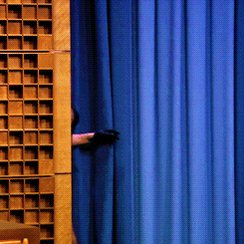

In [91]:
Image.open('annotated-data/1435739987492982789.jpg')

In [ ]:
def label_propagation():
    